In [12]:
import math, random
import sys
sys.path.insert(0,'/root/anaconda3/lib/python3.6/site-packages/')
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [14]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [21]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward , done):
        state      = np.expand_dims(state, 0) 
            
        self.buffer.append((state, action, reward,   done))
    
    def sample(self, batch_size):
        state, action, reward,done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state),np.concatenate( action), reward,   done
    
    def __len__(self):
        return len(self.buffer)

<h2>Environment</h2>

In [22]:
import gym
from gym import spaces

class customizedEnv(gym.Env):

    def __init__(self, df):
        super(customizedEnv, self).__init__()

        pass

    def _take_action(self, action):
        pass

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        reward = self.balance * delay_modifier
        return  reward

    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

<h2>Epsilon greedy exploration</h2>

In [23]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

<h2>Deep Q Network</h2>

In [25]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions,hidden_dim):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=args.solDim,out_channels=hidden_dim,kernel_size=1)
        self.conv2 =  nn.Conv1d(in_channels=hidden_dim,out_channels=args.solDim,kernel_size=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout= nn.Dropout(0.02)

    def forward(self, x):
        x= self.conv1(x)
        x= self.relu(x)
        x=self.conv2 (x)
        if frame_idx<100:
            x=self.dropout(x)
        x= self.sigmoid(x)
        return x
    
    def act(self, state, epsilon):
        if random.random()>0: #> epsilon:
            action = self.forward(state)
        else:
            action = torch.from_numpy(np.array([np.random.choice([0,1],p=[1-args.card/args.solDim,args.card/args.solDim])  for _ in range(args.solDim)])).view([1,args.solDim,1])        
        return action

<h2>Computing Temporal Difference Loss</h2>

In [26]:
def compute_td_loss(batch_size):
    state, action, reward,   done = replay_buffer.sample(batch_size)
    #print('hhhhhhhhhhhstatestate',state)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    #print('hhhhhhhhhhh',action)
    action     = Variable(torch.FloatTensor(np.float32(action)))#Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    print('-----------reward',reward)
    loss=-reward
    loss = loss.requires_grad_()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [27]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

In [60]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys

import numpy as np
from numpy.random import permutation

from grid_data import GridData

from compute_mpe import CircuitMPE

cmpe = CircuitMPE('/root/PySDD/notebooks/syn200.vtree', '/root/PySDD/notebooks/syn200.sdd')
rateList=np.load('rateListSyn200.npy')
Q=np.load('Q.npy')
Q=torch.from_numpy(Q).float()
#cmpe = CircuitMPE('4-grid-out.vtree.sd', '4-grid-all-pairs-sd.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=2
        self.solDim=200
        self.card=20
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=50
args=para()

torch.manual_seed(args.seed) # 设置随机种子，保证可重复性

use_cuda = True#not args.no_cuda and torch.cuda.is_available() # 根据输入参数和实际cuda的有无决定是否使用GPU
device = torch.device("cuda") # if use_cuda else "cpu" 设置使用CPU or GPU
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {} # 设置数据加载的子进程数；是否返回之前将张量复制到cuda的页锁定内存
hidden_dim=10

num_frames = 10000
batch_size = 1
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
tmp= np.random.random(2) 


torch.manual_seed(args.seed) # 设置随机种子，保证可重复性

use_cuda = True#not args.no_cuda and torch.cuda.is_available() # 根据输入参数和实际cuda的有无决定是否使用GPU
device = torch.device("cuda") # if use_cuda else "cpu" 设置使用CPU or GPU
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {} # 设置数据加载的子进程数；是否返回之前将张量复制到cuda的页锁定内存
hidden_dim=args.hidden_dim
fmin,fmax,gmin,gmax=None,None,None,None

model = DQN(args.solDim,args.solDim,args.hidden_dim)
def weights_init(mod):
    """设计初始化函数"""
    classname=mod.__class__.__name__
    # 返回传入的module类型
    print(classname)
    if classname.find('Conv')!= -1:    #这里的Conv和BatchNnorm是torc.nn里的形式
        mod.weight.data.normal_(-0.1,0.2)
    elif classname.find('BatchNorm')!= -1:
        mod.weight.data.normal_(1.0,0.2) #bn层里初始化γ，服从（1，0.02）的正态分布
        mod.bias.data.fill_(0)  #bn层里初始化β，默认为0

model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum) # 实例化求解器

replay_buffer = ReplayBuffer(1000)
for frame_idx in range(1, num_frames + 1):
    done=0
    state=torch.from_numpy(np.array([0.02]*args.solDim).astype(np.float32)).view([1,args.solDim,1])
    epsilon =epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    if type(action)==np.ndarray:
        output = torch.from_numpy(action).view([1,args.solDim,1])#.detach().numpy()[0]  # 喂入数据并前向传播获取输出
    else:
        output = action
    #print(output)
    yu=torch.unbind(output, axis=1)
    xu = torch.unbind(state, axis=1)
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu])
    reward =-((sum(output[0])-args.card)**2-args.wmc*torch.log(torch.mean(wmc)).float()-torch.mm(torch.mm((action[0]>0.5).float().view([1,args.solDim]),Q),(action[0]>0.5).float().view([args.solDim,1]))) #+5*(sum(sorted(rateList[:args.solDim])[-args.card:])-torch.mm((output[0]>0.5).float().view([1,args.solDim]),torch.from_numpy(np.array(rateList[:args.solDim])).float().view([args.solDim,1])))
    replay_buffer.push(state.detach().numpy(),output.detach().numpy(), reward,  done)

    episode_reward += reward
    done=1

    loss=(sum(output[0])-args.card)**2-args.wmc*torch.log(torch.mean(wmc)).float()-torch.mm(torch.mm((action[0]>0.5).float().view([1,args.solDim]),Q),(action[0]>0.5).float().view([args.solDim,1])) 
    loss = loss.requires_grad_()
    print(reward,sum((action[0]>0.5)).item() ,torch.mm(torch.mm((action[0]>0.5).float().view([1,args.solDim]),Q),(action[0]>0.5).float().view([args.solDim,1])) )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])
        
    if frame_idx % 30 == 0:
        state, action, reward,   done = replay_buffer.sample(batch_size)
        #print('hhhhhhhhhhhstatestate',state)
        state      = Variable(torch.FloatTensor(np.float32(state)))
        #print('hhhhhhhhhhh',action)
        action     = Variable(torch.FloatTensor(np.float32(action)))#Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        print(reward,sum((action[0]>0.5)).item() ,torch.mm(torch.mm((action[0]>0.5).float().view([1,args.solDim]),Q.to(device)),(action[0]>0.5).float().view([args.solDim,1])) )

        loss=-reward
        loss = loss.requires_grad_()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

Conv1d
Conv1d
ReLU
Sigmoid
Dropout
DQN
tensor([[-2276.1484]], grad_fn=<NegBackward>) 91 tensor([[4141.2207]])
tensor([[-143.7913]], grad_fn=<NegBackward>) 3 tensor([[5.1151]])
tensor([[-144.6630]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-162.8588]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-162.5159]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-131.5562]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-117.6095]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-97.1982]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-171.3559]], grad_fn=<NegBackward>) 5 tensor([[12.0568]])
tensor([[-85.4073]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-139.7179]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-139.5308]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-179.1825]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-115.2146]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([[-132.3912]], 

tensor([[-176.8441]], grad_fn=<NegBackward>) 6 tensor([[17.5201]])
tensor([-176.8509], device='cuda:0') 6 tensor([[17.5201]], device='cuda:0')


KeyboardInterrupt: 

<p><hr></p>

In [59]:
torch.mm(torch.mm((action[0]>0.5).float().view([1,args.solDim]),Q.to(device)),(action[0]>0.5).float().view([args.solDim,1]))

tensor([[17.5201]], device='cuda:0')

tensor([[4141.2217]], device='cuda:0')

<h1>Atari Environment</h1>

In [ ]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [ ]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [ ]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [26]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

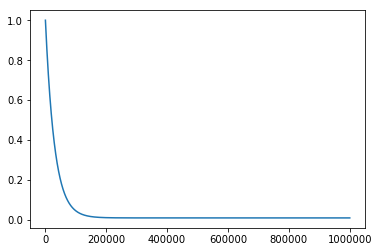

In [27]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])